Build and train a Recurrent Neural Network (RNN) of the type LSTM to predict $X(k)$ and $Y(k)$  as respectively  $\tilde{X(k)}$ an  $\tilde{Y(k)}$ based on inputs

Predictions on testing set are done in [RNN_Sim_StLaurentDeJourdes](RNN_Sim_StLaurentDeJourdes.ipynb)

---

In [3]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf

In [4]:
import joblib

In [5]:
# import pakages forML
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [7]:
# import psutil
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import myFunctions as mf
from myFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

In [8]:
#Import Networks
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

##### Compute the totalpower  of BT prod and Load on St Laurent 


In [9]:
# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT =net_stlaurent.sgen[net_stlaurent.sgen.name.isna()].max_p_mw.sum()
sum_max_p_mw_StLaurent_load = net_stlaurent.load.max_p_mw.sum()

# To use later in functions 
sum_max_main_network = (sum_max_p_mw_StLaurent_prodBT, sum_max_p_mw_StLaurent_load)


In [10]:
# Each row representing the data of an hour, 
nb_day_2020 = 366 
nb_hour_day = 24 
row2read = nb_day_2020*nb_hour_day # Total number of rows for year 2020

#Load files
file_p_inj_0013 = 'Prod_HTA/PROD_Bis/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/PROD_Bis/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'

file_p_inj_0100 = 'Prod_HTA/PROD_Bis/PROD-SERGIES 2204 (LA ROCHE A CORNUCHON)-PINDRAY - Actif P-.csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'

# The  commissioning of the Prod P0100 is recent (2022). I upscale the prod P0013 (*10)
# and consider it as that of Prod P0100 and then complete with the real production of P0100 
# for the said year
upscale_factor = 10

# Get files data 
p_mw_0013 = mf.readAndReshape_input(file_p_inj_0013 ,excel_folder, )
p_mw_0018 = mf.readAndReshape_input(file_p_inj_0018 ,excel_folder,)
p_mw_0100 = mf.readAndReshape_input(file_p_inj_0100 ,excel_folder,)



# p_mw_0100_bis = p_mw_0013*upscale_factor
p_mw_prod_bt_total = mf.readAndReshape_input(file_prod_bt_total, excel_folder)
p_mw_cons_total = mf.readAndReshape_input(file_cons_total, excel_folder)

# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013[:len(p_mw_0100)], 
                'P0018': p_mw_0018[:len(p_mw_0100)],
                'P0100': p_mw_0100[:len(p_mw_0100)]
               }
# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0100), freq='10T')

# Use the create dict to create a dataFrame for Prod P0100
df_prodP0100 = pd.DataFrame(p_mw_0100, index=per_index)

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# Dataframe prod BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_prod_bt_total), freq='10T')
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])

# Dataframe Conso BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_cons_total), freq='10T')
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index, columns=['Cons'])

# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = net_civaux.sgen.max_p_mw[net_civaux.sgen.name.isna()].sum()

# # Get total power of load in the network
max_p_mw_total_load = net_civaux.load.max_p_mw.sum()

# Select only 2020 and 2021 data
df_prodHT = df_prodHT[df_prodHT.index<='2021 12 31 23:50']
df_prod_bt_total = df_prod_bt_total[df_prod_bt_total.index<='2021 12 31 23:50']
df_cons_total = df_cons_total[df_cons_total.index<='2021 12 31 23:50']

### Data Cleaning 
See [STLaurentDeJourdes_2](STLaurentDeJourdes_2.ipynb) for a better understanding of what is don ein the following cell

In [11]:
per_index = df_cons_total.index

max_indx = df_cons_total.Cons.argmax()  # Get the indice of the period where the pic occurs
# replace the value with the mean of the previous and following periods
df_cons_total.Cons[max_indx] = (df_cons_total.Cons[max_indx-1] + df_cons_total.Cons[max_indx-1])/2


# Replacing wrong data by the mean of surrounding periods
previous_days = df_cons_total[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50')]
following_days = df_cons_total[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50')]
# Put the interpolated data into the dataframe
df_cons_total[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2

# Replacing missing data by the mean of surrondings periods
# Extract previous and following days 
previous_days = df_prodHT.loc[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50'),['P0013','P0018']]
following_days = df_prodHT.loc[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50'),['P0013','P0018']]

# Put the interpolated data into the dataframe
df_prodHT.loc[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50'), ['P0013','P0018']] = (np.array(following_days) + 
                                                                          np.array(previous_days) )/2

# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. Each day total period is therefore given by 10*6
# h_start_end = ('07:00','18:50')
h_start_end = ('06:00','19:50')

per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])

#### Create dataFrame to use and separate training and validation set

In [12]:
# Put all the data in a unique dataframe
df_data = pd.concat([df_cons_total, df_prod_bt_total, df_prodHT], axis=1).loc[per_daylight]

# Add categorical data
df_data['Month'] = df_data.index.month
df_data['Days'] = df_data.index.day_of_week
df_data['hour'] = df_data.index.hour
df_data['Minutes'] = df_data.index.minute

# # Separate training and validation set 
df_train = df_data[df_data.index<'2021 06 01']
df_val = df_data[df_data.index>='2021 06 01']

#### Create Seasonal data

In [35]:
dayInMin


1440

In [36]:
dayInMin = 60*13 # 13
weekInMin = dayInMin*7
yearInMin = dayInMin*365.25

hourly_cycle =   np.cos(df_data.Minutes*(2*np.pi/60))
daily_cycle =  np.cos((df_data.hour*60+df_data.Minutes)*2*np.pi/dayInMin)
weekly_cycle = np.cos((dayInMin*df_data.Days +60*df_data.hour+df_data.Minutes)*2*np.pi/weekInMin)
yearly_cycle = np.cos((dayInMin*df_data.index.dayofyear +60*df_data.hour+df_data.Minutes)*2*np.pi/yearInMin)

cycle_datadict = {name: elm.values for name, elm in zip(['hourly_cycle', 'daily_cycle', 'weekly_cycle', 'yearly_cycle'],
                                                        [hourly_cycle,daily_cycle,weekly_cycle,yearly_cycle])}
df_cycleData = pd.DataFrame(data=cycle_datadict, index=df_data.index)

# # Separate training and validation set 
df_train_cycle = df_cycleData[df_cycleData.index<'2021 06 01']
df_val_cycle = df_cycleData[df_cycleData.index>='2021 06 01']



df_data.Cons[df_data.Cons<=2]=df_data.Cons.mean() # Replace all the periods where 
                                                  # the consumption is lower than 2 MWh by the mean

max_jan = df_data.Cons[df_data.index.month==1].max() # Get the maximum consumption 
                                                     # from the higher consumption month i.e. January
df_data.Cons[df_data.Cons>max_jan]= max_jan   # Replace all the periods where 
                                              # the consumption is higher than max_jan by max_jan


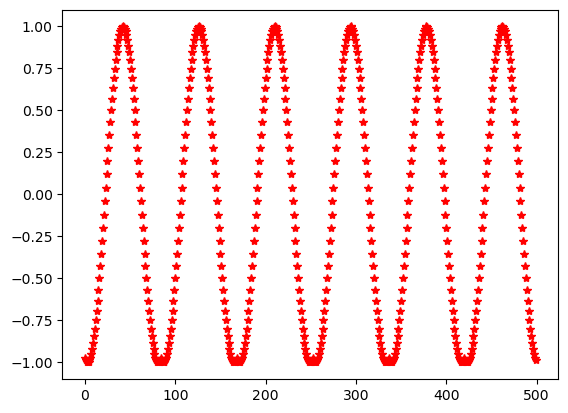

In [37]:
plt.plot(daily_cycle.values[:500], '*r')

#### Plot data

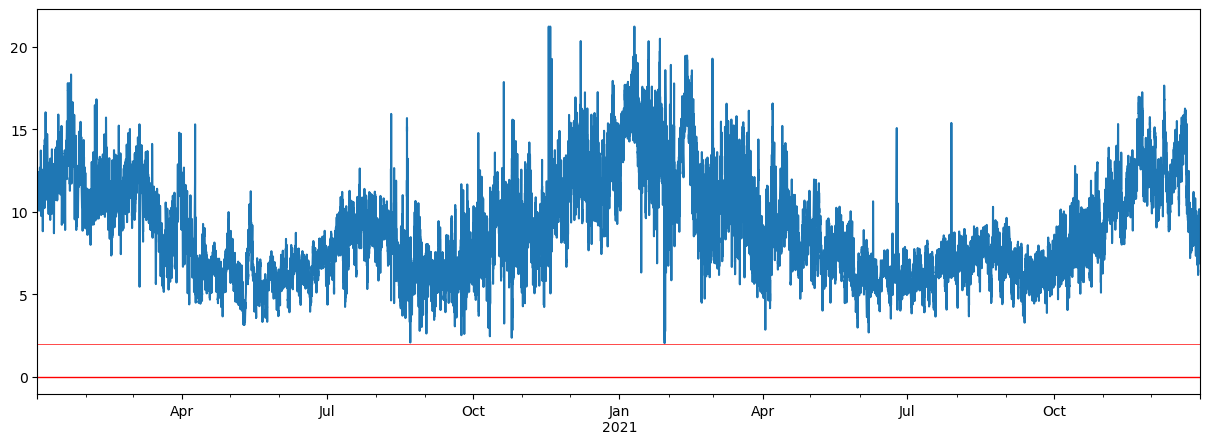

In [51]:
plt.figure(figsize=(15,5))
df_data.Cons.iloc[:300500].plot()
plt.axhline(0, lw=1, c='r')
plt.axhline(2, lw=.5, c='r')
# plt.axhline(5, lw=.5, c='r')

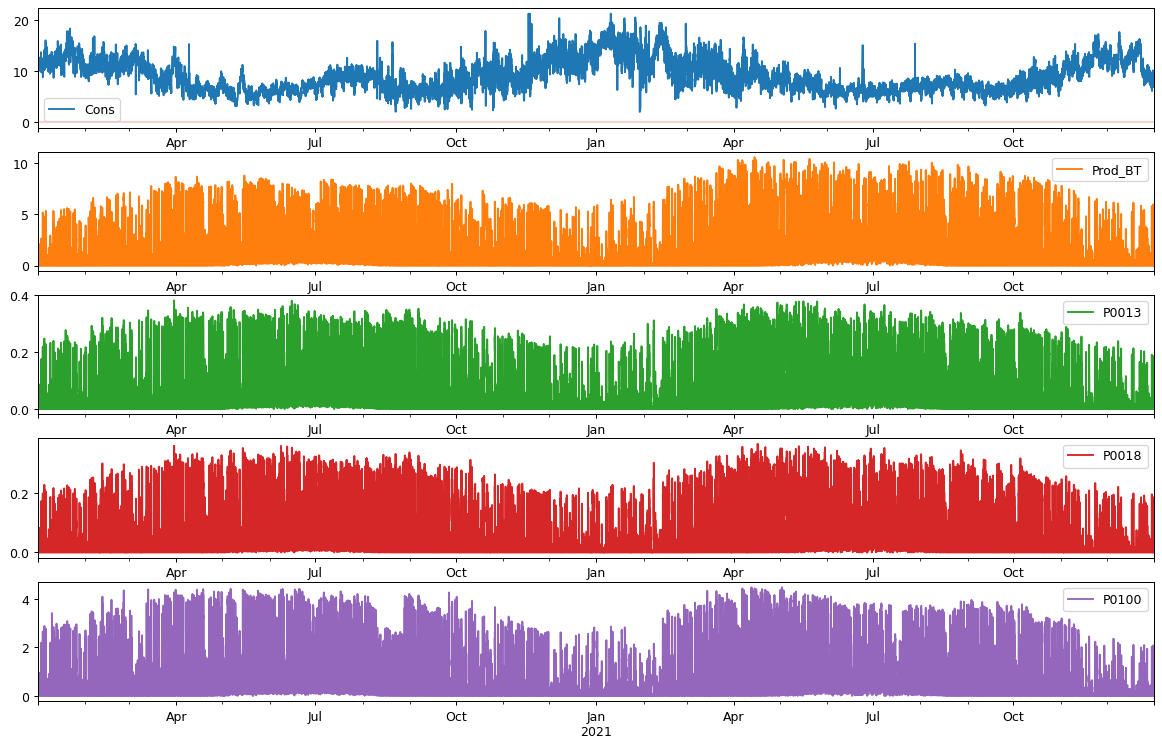

In [52]:
fig, axx = plt.subplots(5,figsize=(16,10),dpi=90)
df_data.iloc[:,:5].plot(subplots=True,ax=axx);
axx[0].axhline(0, color='red', lw=0.3)

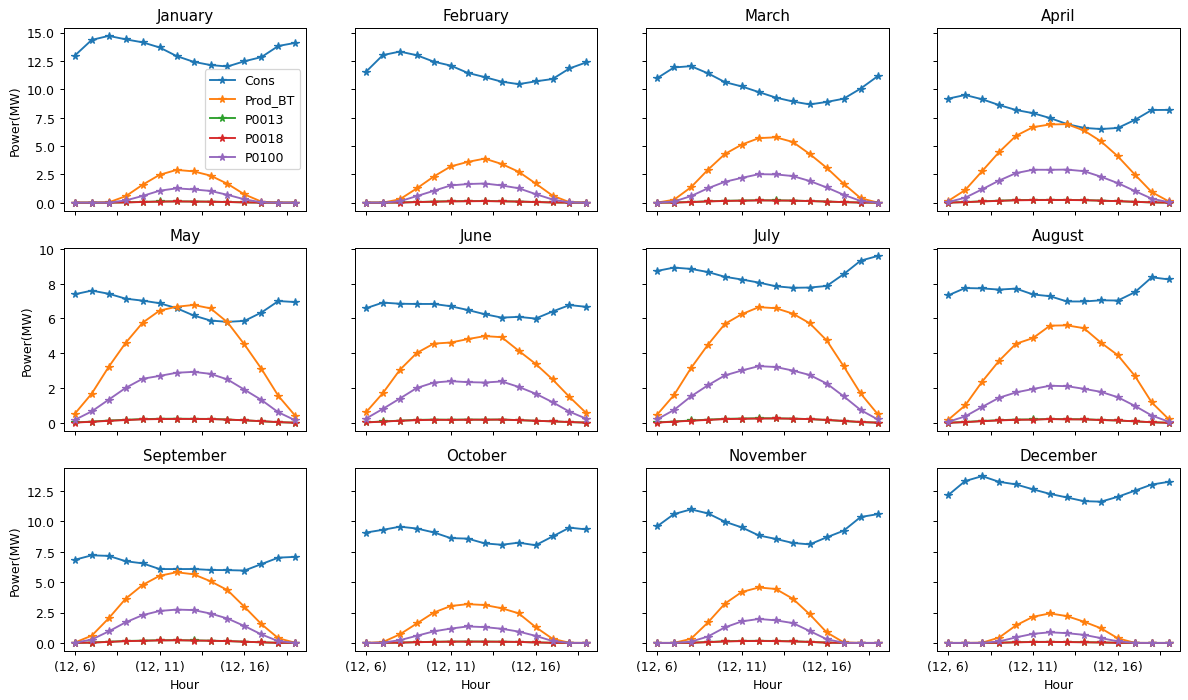

In [53]:
month_names_list = df_train.index.to_timestamp().month_name().unique();
fig, axx = plt.subplots(3,4, figsize=(16,9), dpi=90, sharey='row', sharex=True)
to_plot = df_train.iloc[:,[0,1,2,3,4,5,7]].groupby(by=[ 'Month', 'hour'],).mean().groupby(by='Month')
        

for elm, cur_axx in zip(to_plot, axx.flatten()):
    # Plot legend on the first subplot()
    if elm[0] == 1 :
        elm[1].plot(ax=cur_axx,marker='*',  xlabel='',ylabel = 'Power(MW)', title=month_names_list[elm[0]-1])
        var = day_tot_per//6
        # cur_axx.set_xticks(range(0, var), labels=range(7,7+var))
        # cur_axx.semilogy()
    else:    
        elm[1].plot(ax=cur_axx, marker='*',legend=False, xlabel='Hour', ylabel = 'Power(MW)', title=month_names_list[elm[0]-1])
        # cur_axx.set_xticks(range(0, var), labels=range(7,7+var))
        # cur_axx.set_xticks(range(0,10), labels=range(8,18))
        # cur_axx.semilogy()
        
# fig.tight_layout()

#### Train RNN

In [54]:
from sklearn.compose import ColumnTransformer

In [55]:
# Define Scalers
numerical_scaler = MinMaxScaler()    
numerical_scaler_cycle = MinMaxScaler()    
categorical_scaler = OneHotEncoder(sparse=False) # Sparse : False is used to avoid creating sparse matrix

n_features = 5    # 'Cons', 'Prod_BT', 'P0013', 'P0018', 'P0100'

# Define types columns  
cat_cols = df_train.columns[n_features:]  # Categorical Column i.e ['Month', Hour]
num_cols = df_train.columns[:n_features]  # Numerical Columns  i.e all others


numerical_scaler.fit(df_train.loc[:,num_cols])    # Fit scaler to the training set numerical inputs
numerical_scaler_cycle.fit(df_train_cycle)    # Fit scaler to the training set numerical inputs
categorical_scaler.fit(df_train.loc[:,cat_cols])  # Fit scaler to the training set categorical input


# Transform (i.e. scaled ) training and validation set following the fitting previously donne
train_scaled_num, val_scaled_num = map(numerical_scaler.transform, 
                                       [df_train.loc[:,num_cols], df_val.loc[:,num_cols ]] 
                                      )

train_scaled_cycle, val_scaled_cycle = map(numerical_scaler_cycle.transform, 
                                       [df_train_cycle, df_val_cycle]
                                      )

train_scaled_cat, val_scaled_cat = map(categorical_scaler.transform, 
                                       [df_train.loc[:,cat_cols], df_val.loc[:,cat_cols ]] 
                                      )

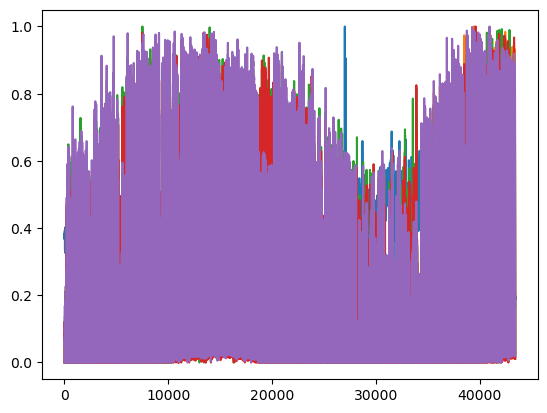

In [56]:
plt.plot(train_scaled_num);

##### Import the RNN

In [92]:
mixed_model = tf.keras.models.load_model("pickle_files/RNN/Multi_Input")

mixed_model.compile(optimizer='adam', loss='mse',metrics=['accuracy'] )

In [93]:
# Define early stoping mecanism to stop training when overfitting start occuring
early_stop = EarlyStopping(monitor= 'val_loss',patience=15, mode='min')

##### Train Model

In [89]:
# Create my ow generator
class MyOwnGenerator:
    def __init__(self, *kwargs): # THis function is used to intanciante the generator
        
        self.len_kwargs = len(kwargs)
        if self.len_kwargs==1:
            self.myinput = kwargs[0];
        elif(self.len_kwargs==2 ):
            self.myinput = kwargs[0];
            self.myinput2 = kwargs[1];
        else:
            raise ValueError( "The generator must be initalized with 1 or two 2 variables")
        
        
    def __len__(self):           # get len of the input data 
        return len(self.myinput)
    
    
    def __getitem__(self, idx):  # function that will be used when the generator is called after initilization
        
        y = self.myinput[idx][1]
        
        if self.len_kwargs == 1 :  # If only one input return a dataset with only the input and output to predict
            x = self.myinput[idx][0]
            return x,y
        else: # If two inputs return a dataset with the both inputs and output to predict
            x = self.myinput[idx][0]
            x2 = self.myinput2[idx][0]
            return (x,x2),y
    
    
    def __call__(self):           # Atch each called of the generator 
        for i in range(self.__len__() -1 ):
            yield self.__getitem__(i)
            

In [90]:
n1_timestep = 60     # Total number of time step to consider as input            
n2_timestep = 18      # Total number of time step to consider as input
n_batch  = 60        # TOtal number of batches


# data_input = np.round(train_scaled_num[:1000], decimals=3)
# tot_batch = len(data_input[n1_timestep:]) # Total batch in the dataset
# ns_end = tot_batch%(n1_timestep*n_batch)  # number of elements to remove in data_input so that the 
#                                          # last element created by the keras.utils has exactly n batches

# numeric_input = tf.keras.utils.timeseries_dataset_from_array(data=data_input[:-(ns_end+1)],
#                                                              targets=data_input[n1_timestep:],
#                                                              sequence_length=n1_timestep, 
#                                                              batch_size=n_batch)
# ll1 = list(numeric_input)

# Create a generator for the categorical and numerical inputs Trainig Set
tsGen_numInput_train = TimeseriesGenerator(data=train_scaled_num, targets=train_scaled_num, 
                                           length=n1_timestep,  batch_size=n_batch)

tsGen_catInput_train = TimeseriesGenerator(data=train_scaled_cat, targets=train_scaled_num, 
                                          length=n2_timestep,  batch_size=n_batch)

tsGen_cycleInput_train = TimeseriesGenerator(data=train_scaled_cycle, targets=train_scaled_num, 
                                          length=n2_timestep,  batch_size=n_batch)


# Create a generator for the categorical and numerical inputs Validation Set
tsGen_numInput_val = TimeseriesGenerator(data= val_scaled_num, targets=val_scaled_num,
                                      length=n1_timestep, batch_size=n_batch)

tsGen_catInput_val = TimeseriesGenerator(data=val_scaled_cat, targets=val_scaled_num,
                                    length=n2_timestep, batch_size=n_batch, )


tsGen_cycleInput_val = TimeseriesGenerator(data=val_scaled_cycle, targets=val_scaled_num,
                                         length=n2_timestep, batch_size=n_batch, )



# Specify input and output type for the Trainig set
spec_input1 = tf.TensorSpec(shape=[n_batch, n1_timestep ,n_features], dtype=tf.float32)
# spec_input2 = tf.TensorSpec(shape=[n_batch, n2_timestep ,len(train_scaled_cat[0])], dtype=tf.float32)
spec_input2 = tf.TensorSpec(shape=[n_batch, n2_timestep ,len(train_scaled_cycle[0])], dtype=tf.float32)
spec_output = tf.TensorSpec(shape=[n_batch, n_features], dtype=tf.float32)
# Create training DataSet
trainDataset = tf.data.Dataset.from_generator(MyOwnGenerator(tsGen_numInput_train, tsGen_cycleInput_train), 
                                                             output_signature=((spec_input1, spec_input2), spec_output))

valDataset = tf.data.Dataset.from_generator(MyOwnGenerator(tsGen_numInput_val, tsGen_cycleInput_val), 
                                                             output_signature=((spec_input1, spec_input2), spec_output))


# # Specify input and output type for the Trainig set
# # spec_input1 = tf.TensorSpec(shape=[n_batch, n1_timestep ,n_features], dtype=tf.float32)
# spec_input2 = tf.TensorSpec(shape=[n_batch, n2_timestep ,len(train_scaled_cat[0])], dtype=tf.bool)
# spec_output = tf.TensorSpec(shape=[n_batch, n_features], dtype=tf.float32)
# # Create training DataSet
# trainDataset = tf.data.Dataset.from_generator(MyOwnGenerator(tsGen_catInput_train), 
#                                                              output_signature=(spec_input2, spec_output))

# valDataset = tf.data.Dataset.from_generator(MyOwnGenerator(tsGen_catInput_val), 
#                                                              output_signature=(spec_input2, spec_output))

In [91]:
mixed_model.fit(trainDataset,
                epochs=200, 
                callbacks=early_stop, 
                validation_data=valDataset
                )

Epoch 1/200
722/722 [==============================] - 58s 79ms/step - loss: 0.0061 - accuracy: 0.7456 - val_loss: 0.0052 - val_accuracy: 0.7779
Epoch 2/200
722/722 [==============================] - 62s 85ms/step - loss: 0.0037 - accuracy: 0.7921 - val_loss: 0.0039 - val_accuracy: 0.8100
Epoch 3/200
722/722 [==============================] - 65s 90ms/step - loss: 0.0033 - accuracy: 0.8055 - val_loss: 0.0035 - val_accuracy: 0.8228
Epoch 4/200
722/722 [==============================] - 64s 88ms/step - loss: 0.0031 - accuracy: 0.8136 - val_loss: 0.0033 - val_accuracy: 0.8301
Epoch 5/200
722/722 [==============================] - 66s 91ms/step - loss: 0.0030 - accuracy: 0.8163 - val_loss: 0.0033 - val_accuracy: 0.8330
Epoch 6/200
722/722 [==============================] - 64s 89ms/step - loss: 0.0029 - accuracy: 0.8170 - val_loss: 0.0033 - val_accuracy: 0.8335
Epoch 7/200
722/722 [==============================] - 65s 90ms/step - loss: 0.0029 - accuracy: 0.8172 - val_loss: 0.0033 - val_ac

In [76]:
mixed_model.fit(trainDataset,
                epochs=200, 
                callbacks=early_stop, 
                validation_data=valDataset
                )

Epoch 1/200
722/722 [==============================] - 47s 64ms/step - loss: 0.0303 - accuracy: 0.7595 - val_loss: 0.0277 - val_accuracy: 0.7696
Epoch 2/200
722/722 [==============================] - 47s 65ms/step - loss: 0.0288 - accuracy: 0.7985 - val_loss: 0.0264 - val_accuracy: 0.7990
Epoch 3/200
722/722 [==============================] - 49s 68ms/step - loss: 0.0087 - accuracy: 0.7894 - val_loss: 0.0037 - val_accuracy: 0.8147
Epoch 4/200
722/722 [==============================] - 49s 67ms/step - loss: 0.0030 - accuracy: 0.8149 - val_loss: 0.0034 - val_accuracy: 0.8195
Epoch 5/200
722/722 [==============================] - 56s 77ms/step - loss: 0.0029 - accuracy: 0.8180 - val_loss: 0.0034 - val_accuracy: 0.8204
Epoch 6/200
722/722 [==============================] - 57s 79ms/step - loss: 0.0029 - accuracy: 0.8193 - val_loss: 0.0034 - val_accuracy: 0.8228
Epoch 7/200
722/722 [==============================] - 53s 73ms/step - loss: 0.0029 - accuracy: 0.8197 - val_loss: 0.0033 - val_ac

In [ ]:
mixed_model.fit(trainDataset,
                epochs=200, 
                callbacks=early_stop, 
                validation_data=valDataset
                )

Epoch 1/200
722/722 [==============================] - 69s 93ms/step - loss: 0.0308 - accuracy: 0.7378 - val_loss: 0.0251 - val_accuracy: 0.8292
Epoch 2/200
722/722 [==============================] - 73s 101ms/step - loss: 0.0306 - accuracy: 0.7404 - val_loss: 0.0248 - val_accuracy: 0.8327
Epoch 3/200
722/722 [==============================] - 76s 106ms/step - loss: 0.0304 - accuracy: 0.7416 - val_loss: 0.0247 - val_accuracy: 0.8349
Epoch 4/200
722/722 [==============================] - 80s 111ms/step - loss: 0.0304 - accuracy: 0.7420 - val_loss: 0.0246 - val_accuracy: 0.8353
Epoch 5/200
722/722 [==============================] - 85s 117ms/step - loss: 0.0303 - accuracy: 0.7424 - val_loss: 0.0245 - val_accuracy: 0.8345
Epoch 6/200
722/722 [==============================] - 83s 115ms/step - loss: 0.0303 - accuracy: 0.7430 - val_loss: 0.0245 - val_accuracy: 0.8345
Epoch 7/200
722/722 [==============================] - 83s 116ms/step - loss: 0.0211 - accuracy: 0.7453 - val_loss: 0.0042 - 

In [150]:
mixed_model.fit(trainDataset,
                epochs=200, 
                callbacks=early_stop, 
                validation_data=valDataset
                )

Epoch 1/200
1239/1239 [==============================] - 229s 183ms/step - loss: 0.0310 - accuracy: 0.8173 - val_loss: 0.0188 - val_accuracy: 0.8427
Epoch 2/200
1239/1239 [==============================] - 257s 207ms/step - loss: 0.0181 - accuracy: 0.8597 - val_loss: 0.0166 - val_accuracy: 0.8632
Epoch 3/200
1239/1239 [==============================] - 250s 202ms/step - loss: 0.0176 - accuracy: 0.8626 - val_loss: 0.0160 - val_accuracy: 0.8719
Epoch 4/200
1239/1239 [==============================] - 272s 219ms/step - loss: 0.0174 - accuracy: 0.8670 - val_loss: 0.0157 - val_accuracy: 0.8761
Epoch 5/200
1239/1239 [==============================] - 270s 218ms/step - loss: 0.0173 - accuracy: 0.8705 - val_loss: 0.0156 - val_accuracy: 0.8807
Epoch 6/200
1239/1239 [==============================] - 316s 255ms/step - loss: 0.0173 - accuracy: 0.8738 - val_loss: 0.0154 - val_accuracy: 0.8846
Epoch 7/200
1239/1239 [==============================] - 251s 202ms/step - loss: 0.0172 - accuracy: 0.8777

KeyboardInterrupt: 

In [80]:
mixed_model.predict((ll[0][0][0], ll[0][0][0]))

NameError: name 'll' is not defined

In [646]:
for batch in benge.batch(1):
    x, y =batch

In [558]:
aa = trying(ll)
# tf.data.Dataset.from_generator(aa)

In [582]:
def trying(ll):
    for elm1, elm2 in zip(ll, ll):
        yield [elm1[0], elm2[0][0][:3]], elm1[1]

In [584]:
def trying(ll):
    for elm1 in ll:
        bb = elm1[0], elm1[1]
        yield bb

In [629]:
# list(trying(ll))[0]

In [546]:
ar = trying(ll)

In [581]:
n1_timestep = 30                  # Total number of time step to consider as input
n_batch  = 2



data_input = np.round(train_scaled_num[:1000], decimals=3)

tot_batch = len(data_input[n1_timestep:]) # Total batch in the dataset
ns_end = tot_batch%(n1_timestep*n_batch)  # number of elements to remove in data_input so that the 
                                         # last element created by the keras.utils has exactly n batches






Epoch 1/5
485/485 [==============================] - 18s 38ms/step - loss: 0.0013 - accuracy: 0.9093
Epoch 2/5
485/485 [==============================] - 0s 29us/step - loss: 0.0013 - accuracy: 0.9093


<AxesSubplot:>

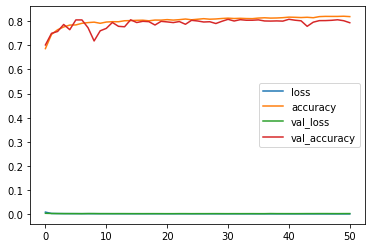

In [20]:
pd.DataFrame(rnn_model.history.history).plot()

In [268]:
# Save model 
# rnn_model.save('pickle_files/RNN/StLaurent_Final')

INFO:tensorflow:Assets written to: pickle_files/RNN/StLaurent_Final\assets


In [112]:
np.linspace(0, len(flights.columns), len(flights.columns) * 1)

array([ 0.        ,  1.09090909,  2.18181818,  3.27272727,  4.36363636,
        5.45454545,  6.54545455,  7.63636364,  8.72727273,  9.81818182,
       10.90909091, 12.        ])

In [111]:
z.shape

(180, 180)

In [95]:
from scipy import ndimage

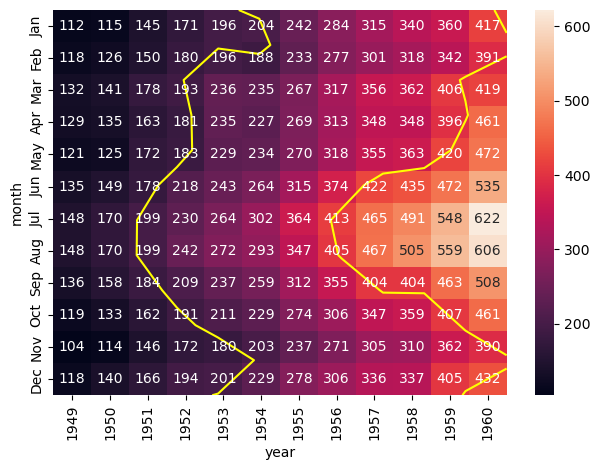

In [114]:
flights = sbn.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
fig, ax = plt.subplots()

smooth_scale = 1
z = ndimage.zoom(flights.to_numpy(), smooth_scale)
cntr = ax.contour(np.linspace(0, len(flights.columns), len(flights.columns) * smooth_scale),
                  np.linspace(0, len(flights.index), len(flights.index) * smooth_scale),
                  z, levels=(200, 400), colors='yellow')
ax = sbn.heatmap(flights, annot=True, fmt='d', cbar=True, ax=ax)

plt.tight_layout()
plt.show()

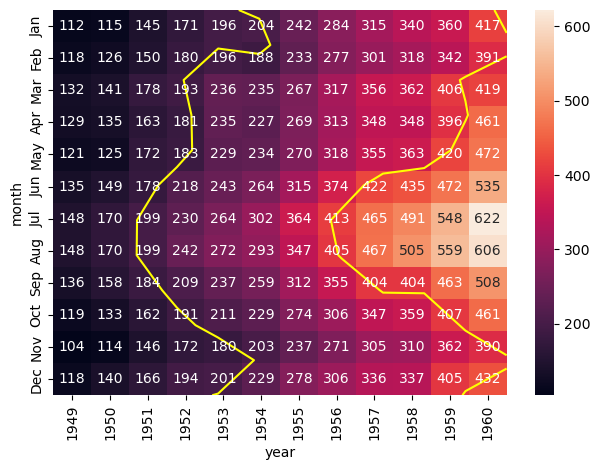

In [100]:
flights = sbn.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
fig, ax = plt.subplots()

smooth_scale = 1
z = ndimage.zoom(flights.to_numpy(), smooth_scale)
cntr = ax.contour(np.linspace(0, len(flights.columns), len(flights.columns) * smooth_scale),
                  np.linspace(0, len(flights.index), len(flights.index) * smooth_scale),
                  z, levels=(200, 400), colors='yellow')
ax = sbn.heatmap(flights, annot=True, fmt='d', cbar=True, ax=ax)

plt.tight_layout()
plt.show()